# Import Libraries

In [30]:
%load_ext autoreload
%autoreload 2
import sys
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools
from itertools import zip_longest
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from torch.optim import Adam, LBFGS
import pickle
import os


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# check for gpu

device = torch.device("mps" if torch.backends.mps.is_available() 
                      else "cuda" if torch.cuda.is_available() 
                      else "cpu")

print('Using device:', device)

Using device: mps


# Fetch the data and models

In [32]:
# Load the loss data from Output
file_path_tr = "job_6265484/train-loss.pkl"

file_path_tt = "job_6265484/test-loss.pkl"




In [45]:


# Load train and test losses
# train_loss = load_pickle(file_path_tr)
with open(file_path_tr, 'rb') as f:
    train_loss = pickle.load(f)
    

loss_train = train_loss
# print(f"Train loss loaded on {device}: {type(train_loss)}")
# print(f"Test loss loaded on {device}: {type(test_loss)}")

# Load the Trained Model
model = torch.load("job_6265484/best-model.pth")


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

# visualise train test Loss

NameError: name 'loss_test' is not defined

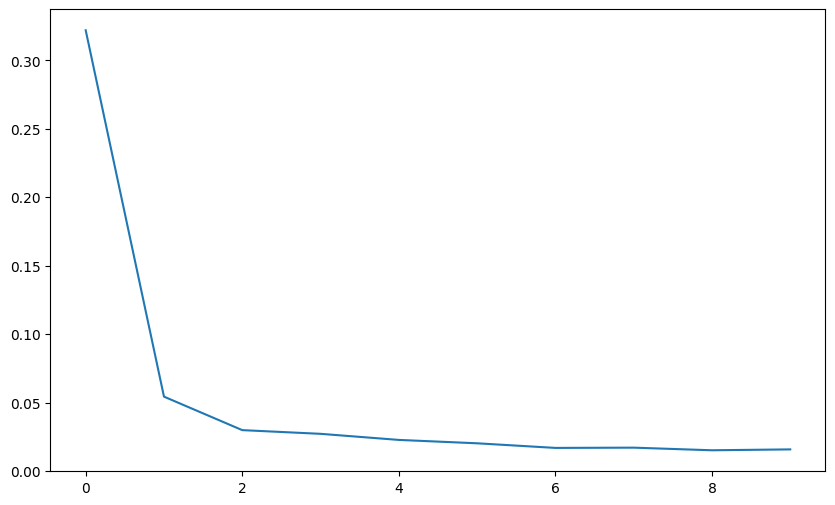

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(loss_train["train-loss"], label='Training Loss')
plt.plot(loss_test["test-loss"], label='test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Visualise PDE losses

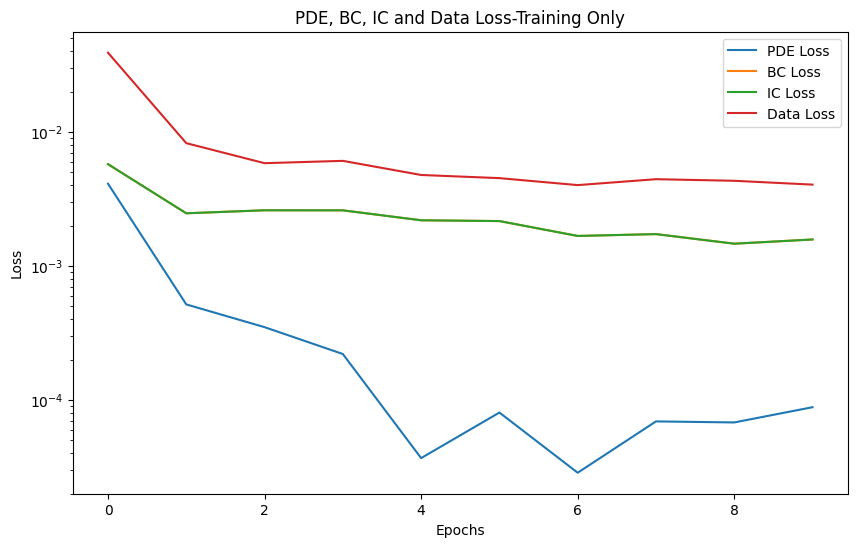

In [43]:
pde_losses = np.array(loss_train["pde-loss"])
bc_losses = np.array(loss_train["bc-loss"])
ic_losses = np.array(loss_train["bc-loss"])

data_losses = np.array(loss_train["data-loss"])

plt.figure(figsize=(10, 6))
plt.plot(pde_losses, label='PDE Loss')
plt.plot(bc_losses, label='BC Loss')
plt.plot(ic_losses, label='IC Loss')
plt.plot(data_losses, label='Data Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('PDE, BC, IC and Data Loss-Training Only')
plt.legend()
plt.show()



# Visualise results at the left, right and centre

In [ ]:
inp_data = input_t
# inp_data = torch.tensor(input_t).float().to(device) # Convert the inputs to a tensor

# load model saved
model = best_model
temp_nn = model(inp_data[:,0].unsqueeze(1), inp_data[:,1].unsqueeze(1)).cpu().detach().numpy() # Get the predictions from the model
dx = heat_data.dx
# temp_nn = invscaler(temp_nn,500.0,919.0) # Inverse transform the predictions
temp_nn = temp_nn * temp_c
temp_nn = temp_nn.reshape(num_steps, numpoints) # Reshape the predictions to a 2D array
time_ss= np.linspace(0, time_end, num_steps )
left , idx, right = 0, 25, 50

fig = plt.figure(figsize=(20, 6))
ax1,ax2,ax3 = fig.subplots(1,3)
ax1.plot(time_ss, temp_nn[:,left], label='Predicted Temperature')
ax1.plot(time_ss, tempfield[:,left], label='Actual Temperature') 
ax1.set_xlabel('Time(s)')
ax1.set_ylabel('Temperature (K)')
ax1.set_title(f'Predicted vs Actual Temperature at x = {(left-1)*dx*1000:.2f} mm')
ax1.legend()

ax2.plot(time_ss, temp_nn[:,idx-1], label='Predicted Temperature')
ax2.plot(time_ss, tempfield[:,idx-1], label='Actual Temperature')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Temperature (K)')
ax2.set_title(f'Predicted vs Actual Temperature at x = {(idx-1)*dx*1000:.2f} mm')
ax2.legend()

ax3.plot(time_ss, temp_nn[:,right-1], label='Predicted Temperature')
ax3.plot(time_ss, tempfield[:,right-1], label='Actual Temperature')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Temperature (K)')
ax3.set_title(f'Predicted vs Actual Temperature at x = {(right-1)*dx*1000:.2f} mm')
ax3.legend()
plt.show()



# Visualsie IC field

In [ ]:
x = np.linspace(0, 15e-3, 100)
t = np.zeros_like(x)

x = torch.tensor(x).float().to(device)
t = torch.tensor(t).float().to(device)
temp_pred = model(x.unsqueeze(1), t.unsqueeze(1)).cpu().detach().numpy()
temp_pred = temp_pred * 919.0
Act_temp = (torch.ones_like(x) * 919.0).cpu().detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(x.cpu().detach().numpy(), temp_pred, label='Predicted Temperature')
plt.plot(x.cpu().detach().numpy(), Act_temp, label='Actual Temperature')
plt.xlabel('Distance (m)')
plt.ylabel('Temperature (K)')
plt.title('Predicted Temperature Distribution along initial condition')
#end


# Visualise Field of the results

In [ ]:
#input data
Act_temp = temp_data * 919.0
Act_temp = Act_temp.reshape(num_steps, numpoints)
print(Act_temp.shape)

input_pred = input_t
temp_nn = model(input_pred[:,0].unsqueeze(1), input_pred[:,1].unsqueeze(1)).cpu().detach().numpy()
temp_nn = temp_nn * 919.0
temp_nn = temp_nn.reshape(num_steps, numpoints)

print(temp_nn.shape)

space_coord, time_coord = np.meshgrid(np.arange(Act_temp.shape[1]), np.arange(Act_temp.shape[0]))
time_coord = time_coord * dt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))



# Plot the temperature history on the left subplot
im1 = ax1.pcolormesh(space_coord, time_coord, Act_temp, cmap='coolwarm')
ax1.set_xlabel('Space Coordinate', fontname='Times New Roman', fontsize=16)
ax1.set_ylabel('Time',fontname='Times New Roman', fontsize=16)
ax1.set_title('Temperature Variation Over Time (Analytical)',fontname='Times New Roman', fontsize=20)
fig.colorbar(im1, ax=ax1, label='Temperature')

im2 = ax2.pcolormesh(space_coord, time_coord, temp_nn, cmap='coolwarm')
ax2.set_xlabel('Space Coordinate', fontname='Times New Roman', fontsize=16)
ax2.set_ylabel('Time',fontname='Times New Roman', fontsize=16)
ax2.set_title('Temperature Variation Over Time(Neural Network)',fontname='Times New Roman', fontsize=20)
fig.colorbar(im2, ax=ax2, label='Temperature')

plt.tight_layout()

plt.show()
